# Mock Data Pipeline

`scippr` requires inputs in the form of catalogs $\{\ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n}, \underline{\phi}^{*}, \vec{\alpha}, \vec{\beta})]\}_{N}$ of interim log-posteriors expressed as `3D` arrays constituting probabilities over $t_{n}$, $z_{n}$, and $\mu_{n}$, enabling rapid computation of the log-posterior $\ln[p(\underline{\phi}, \vec{\Omega} | \{\underline{\ell}_{n}, \vec{f}_{n}\}_{N}, \vec{\alpha}, \vec{\beta})$ over the hyperparameters $\underline{\phi}$ and $\vec{\Omega}$ of scientific interest.  This notebook outlines a procedure for generating such a catalog.

Perhaps the defining feature of this pipeline is that it does not involve simulating supernova lightcurves or host galaxy photometry and instead simulating the interim posteriors directly.  There are several good reasons for this choice:

* The motivation for `scippr` is to develop a method for doing inference with accurate probability distributions over relevant supernova parameters, not to develop methods for obtaining those probability distributions.
* We avoid tying our inference method to a particular way of deriving interim posteriors from observed data.
* We avoid making assumptions about the details of the observed data, such as the photometric filters, intrinsic lightcurves, and observing conditions.

In [1]:
import daft
import astropy.cosmology as cosmology

import numpy as np
import bisect
import scipy.stats as sps
import scipy.interpolate as spi
import scipy.optimize as spo
import hickle
import sys
log_epsilon = sys.float_info.min_exp
epsilon = sys.float_info.min

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)

colors = 'rbgcymk'

`scippr` is based on a probabilistic graphical model, illustrated below.  The model has two types of observables, shown in shaded circles, supernova lightcurves $\underline{\ell}_{n}$ and host galaxy photometry $\vec{f}_{n}$.  The parameters, which are by definition not directly observable, are shown in empty circles.  The latent variables of supernova type $t_{n}$, redshift $z_{n}$, and distance modulus $\mu_{n}$ are parameters over which we will marginalize, without ever directly inferring them, and while all three of them influence $\underline{\ell}_{n}$, only $z_{n}$ affects $\vec{f}_{n}$ in this model.  In other words, _we currently assume no relationship between supernova type and host galaxy photometry, an assumption we may revisit in the future_.  The selection function parameters $\vec{\alpha}$ and $\vec{\beta}$ are known constants of the survey symbolized by dots that influence the possible lightcurves and host galaxy photometry that are included in the sample.  The box indicates that the latent variables and the observables are generated independently $N$ times for each supernova in the sample.  The hyperparameters we would like to estimate are the redshift-dependent supernova type proportions $\underline{\phi}$ that determine $t_{n}$ and $z_{n}$ and the cosmological parameters $\vec{\Omega}$ that relate $z_{n}$ to $\mu_{n}$, which are shared by all $N$ supernovae in the observed sample.  

/tmp/ipykernel_68206/3120151379.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pgm.figure.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/aimalz/Code/LSSTDESC/scippr/code/demos/plots/sim_pgm.png'

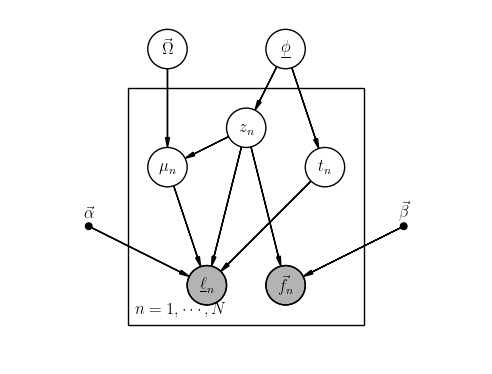

In [2]:
#initialize the PGM
pgm = daft.PGM([6, 4.5], origin=[0, 0])

#desired hyperparameters
pgm.add_node(daft.Node("cosmology", r"$\vec{\Omega}$", 2., 4.))
pgm.add_node(daft.Node("dist", r"$\underline{\phi}$", 3.5, 4.))
#pgm.add_node(daft.Node("rates", r"$\vec{R}$", 3., 5.5, fixed=True))

#latent variables/parameters
pgm.add_node(daft.Node("distance", r"$\mu_{n}$", 2., 2.5))
pgm.add_node(daft.Node("redshift", r"$z_{n}$", 3., 3.))
pgm.add_node(daft.Node("type", r"$t_{n}$", 4., 2.5))

#data
pgm.add_node(daft.Node("lightcurve", r"$\underline{\ell}_{n}$", 2.5, 1., observed=True))
pgm.add_node(daft.Node("photometry", r"$\vec{f}_{n}$", 3.5, 1., observed=True))

#known constant parameters
pgm.add_node(daft.Node("lightcurve selection", r"$\vec{\alpha}$", 1., 1.75, fixed=True))
pgm.add_node(daft.Node("photometry selection", r"$\vec{\beta}$", 5., 1.75, fixed=True))

# Add in the edges.
pgm.add_edge("dist", "type")
pgm.add_edge("cosmology", "distance")
pgm.add_edge("dist", "redshift")
pgm.add_edge("redshift", "distance")
#pgm.add_edge("distance", "photometry")
pgm.add_edge("distance", "lightcurve")
pgm.add_edge("redshift", "photometry")
pgm.add_edge("redshift", "lightcurve")
pgm.add_edge("type", "lightcurve")
pgm.add_edge("photometry selection", "photometry")
pgm.add_edge("lightcurve selection", "lightcurve")

# plates
pgm.add_plate(daft.Plate([1.5, 0.5, 3., 3.], label=r"$n = 1, \cdots, N$"))

# Render and save.
pgm.render()
pgm.figure.show()
pgm.figure.savefig('plots/sim_pgm.png', dpi=250)

To simulate a mock catalog for `scippr`, there are three main steps.

1. Choose true values for the hyperparameters, which we would like to recover from our inference, and the parameters, over which we intend to marginalize.
2. Create likelihoods based on a model for how they are derived from observations under the selection functions.
3. Make interim posteriors by assuming interim priors.

## Choosing true hyperparameters and parameters

### The redshift-dependent supernova type proportions

We assume that the true redshift-dependent type proportions are provided as parameters $\underline{\phi}'$ of continuous functions for a finite number of types across a restricted redshift range.  

*[The following cell is a placeholder for a realistic $\underline{\phi}'$.  It will soon be replaced with reading in a file containing this information.]*

In [3]:
types = ['Ia', 'Ibc', 'II']
n_types = len(types)
# making up the type fractions, will replace this with data soon!
frac_types = np.array([0.4, 0.1, 0.5])
assert np.isclose(np.sum(frac_types), 1.)

min_z = 0.15
max_z = 0.65

n_of_z_consts = {}
n_of_z_consts['Ia'] = (1.5, 0.5)
n_of_z_consts['Ibc'] = (1., 0.5)
n_of_z_consts['II'] = (0.5, 0.5)

true_n_of_z = []
for t in types:
    (mean, std) = n_of_z_consts[t]
    low, high = (min_z - mean) / std, (max_z - mean) / std
    true_n_of_z.append(sps.truncnorm(low, high, loc = mean, scale = std))

plot_res = 20
z_range = max_z - min_z
z_grid = np.linspace(min_z, max_z, num=plot_res + 1, endpoint=True)
z_plot = (z_grid[1:] + z_grid[:-1]) / 2.
z_dif_plot = z_grid[1:] - z_grid[:-1]

Here we plot the true redshift-dependent type proportions after ensuring they are properly normalized.

FileNotFoundError: [Errno 2] No such file or directory: '/home/aimalz/Code/LSSTDESC/scippr/code/demos/plots/true_rates.png'

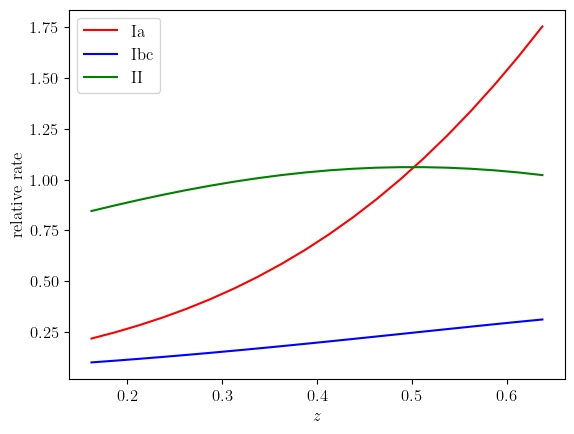

In [4]:
plot_true_n_of_z = np.zeros((n_types, plot_res))
for t in range(n_types):
    plot_true_n_of_z[t] = true_n_of_z[t].pdf(z_plot)
plot_true_n_of_z = frac_types[:, np.newaxis] * np.array(plot_true_n_of_z)# / z_range
plot_true_n_of_z /= np.sum(plot_true_n_of_z * z_dif_plot)
assert np.isclose(np.sum(plot_true_n_of_z * z_dif_plot), 1.)

for t in range(n_types):
    plt.plot(z_plot, plot_true_n_of_z[t], color=colors[t], label=types[t])
plt.xlabel(r'$z$')
plt.ylabel(r'relative rate')
plt.legend()
plt.savefig('plots/true_rates.png')

We sample pairs of type and redshift from these distributions by choosing a type based on the overall type proportions, then sampling its underlying redshift distribution.

In [5]:
def sample_discrete(fracs, n_of_z, N):
    out_info = []
    cdf = np.cumsum(fracs)
    for n in range(N):
        each = {}
        r = np.random.random()
        k = bisect.bisect(cdf, r)
        each['t'] = types[k]
        each['z'] = n_of_z[k].rvs()
        out_info.append(each)
    return out_info

n_sne = 1000

true_params = sample_discrete(frac_types, true_n_of_z, n_sne)

true_zs = [true_param['z'] for true_param in true_params]

Here we plot a histogram of the true redshift values for the three types of supernovae, along with the redshift-dependent type functions from which they were drawn.

AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

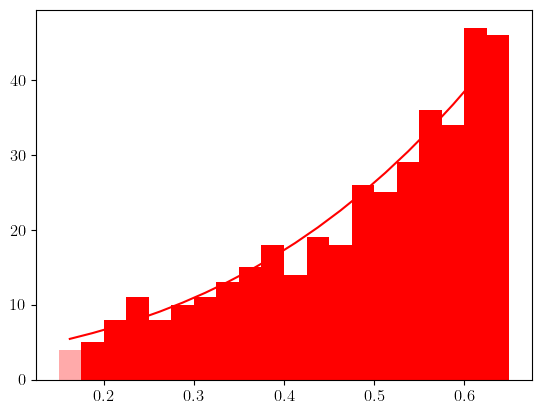

In [6]:
to_plot = [[d['z'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
hist_bins = np.linspace(min_z, max_z, plot_res + 1)
bin_difs = hist_bins[1:] - hist_bins[:-1]
for t in range(n_types):
    plt.plot(z_plot, plot_true_n_of_z[t] * n_sne * bin_difs, color=colors[t], label='true '+types[t])
    plt.hist(to_plot[t], bins=hist_bins, color=colors[t], alpha=1./3., label='sampled '+types[t], normed=False)
plt.xlabel(r'$z$')
plt.ylabel(r'relative rate')
plt.legend(fontsize='xx-small')
plt.savefig('plots/obs_rates.png')

### The true cosmological parameters

We define the true hyperparameter vector $\vec{\Omega}'$ as having two components, $H_{0}'$ and $\Omega_{m,0}'$.  In a future revision, we may include additional cosmological parameters in this hyperparameter vector.  We choose the true values for the cosmological parameters to be those published by /Planck/.  [include citation]  

Since every supernova in our sample already has a true redshift $z_{n}'$, we can easily establish a true distance modulus $\mu_{n}'$ via the luminosity distance equation.  [insert equation here]

In [7]:
# Planck
true_H0 = 67.9
true_Om0 = 1. - 0.693
true_hyperparams = np.array([true_H0, true_Om0])
n_hyperparams = len(true_hyperparams)
true_cosmo = cosmology.FlatLambdaCDM(H0=true_H0, Om0=true_Om0)

for n in range(n_sne):
    true_params[n]['mu'] = true_cosmo.distmod(true_params[n]['z']).value

We plot a traditional Hubble diagram of the supernovae in our sample.

*We must note that this is not a Hubble diagram like any other ever observed!  The distance moduli are of course not accessible for supernovae of types other than Ia.  However, non-Ia supernovae do still have a distance modulus, and do still follow the cosmological Hubble flow, so in simulated data, this is a perfectly reasonable quantity to visualize.*

FileNotFoundError: [Errno 2] No such file or directory: '/home/aimalz/Code/LSSTDESC/scippr/code/demos/plots/true_hubble.png'

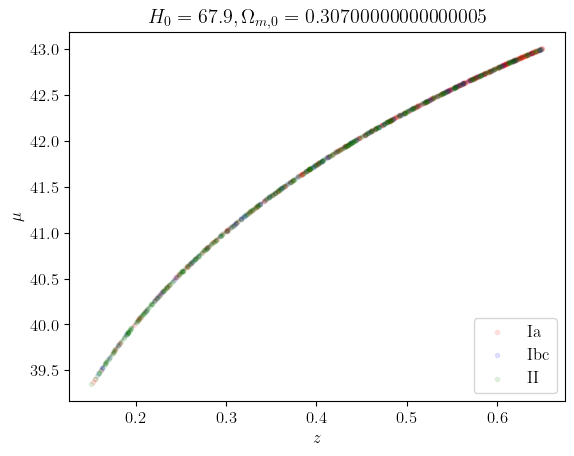

In [8]:
to_plot_x = [[d['z'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
to_plot_y = [[d['mu'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
for t in range(n_types):
    plt.scatter(to_plot_x[t], to_plot_y[t], color=colors[t], marker='.', label=types[t], alpha=0.1)
plt.plot(z_plot, [true_cosmo.distmod(z).value for z in z_plot], color='k', alpha=0.2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend(loc='lower right')
plt.title(r'$H_{0}='+str(true_H0)+r', \Omega_{m,0}='+str(true_Om0)+r'$')
plt.savefig('plots/true_hubble.png')

## Simulating Probabilities

`scippr` is intended to be used on interim posterior probabilities derived from a probabilistic lightcurve fitting procedure.  These will be provided as log-probabilities evaluated on a `3D` grid in type, redshift, and distance modulus space.  We choose to work with arrays of log-probabilities because they preserve numerical precision and enable slower products of arrays to be transformed into fast sums of arrays.  *This choice of parametrization for the input probabilities will be hard to change later on!*

Since we will be working in log-space, it is important to define functions that ensure that the elements of the log-probability arrays do not result in `NaN` values and do not throw errors in the functions used to take logs.  We do this by defining a very small positive number, many orders of magnitude less than the limit of floating point precision, as the minimum probability allowed in our universe.

In [9]:
def safe_log(arr, threshold=epsilon):
#     shape = np.shape(arr)
#     flat = arr.flatten()
#     logged = np.log(np.array([max(a, threshold) for a in flat])).reshape(shape)
    arr[arr < threshold] = threshold
    return np.log(arr)

def reg_vals(arr, threshold=log_epsilon):
    arr[arr < threshold] = threshold
    return arr

We establish a binning in the space of $z$ and $\mu$ for the arrays of log-probabilities.  This is arbitrary and can easily be changed.  [The cell below will be replaced by reading in physically motivated bin limits from a file.]

In [10]:
# this binning is arbitrary!
n_zs = 6
z_bins = np.linspace(min_z, max_z, num=n_zs, endpoint=True)
z_difs = z_bins[1:] - z_bins[:-1]
z_dif = np.mean(z_difs)
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.

# want this to be agnostic about true cosmology
n_mus = 6
min_mu, max_mu = min([s['mu'] for s in true_params]) - 0.5, max([s['mu'] for s in true_params]) + 0.5
mu_bins = np.linspace(min_mu, max_mu, num=n_mus, endpoint=True)
mu_difs = mu_bins[1:] - mu_bins[:-1]
mu_dif = np.mean(mu_difs)
mu_range = np.max(mu_bins) - np.min(mu_bins)
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.

z_mu_grid = np.array([[(z, mu) for mu in mu_mids] for z in z_mids])
cake_shape = np.shape(z_mu_grid)

In [11]:
print(z_mids, mu_mids)

[0.2 0.3 0.4 0.5 0.6] [39.31295339 40.24560903 41.17826468 42.11092032 43.04357596]


### Creating likelihoods

We now simulate likelihoods for the type, redshift, and distance modulus of our sample of supernovae.  This is something that will be done internally by a probabilistic lightcurve fitting procedure.

The goal here is to simulate realistic outputs from such a procedure without having to develop and run one.   Each log-likelihood $\ln[p(\underline{\ell}_{n}, \vec{f}_{n} | t_{n}, z_{n}, \mu_{n}, \vec{\alpha}, \vec{\beta})]$ may be broken down into simpler components that may be summed to create log-likelihoods.

\begin{align*}
\ln[p(\underline{\ell}_{n}, \vec{f}_{n} | t_{n}, z_{n}, \mu_{n}, \vec{\alpha}, \vec{\beta})] &= \ln[p(\underline{\ell}_{n} | t_{n}, z_{n}, \mu_{n}, \vec{\alpha})] + \ln[p(\vec{f}_{n} | z_{n}, \vec{\beta})]
\end{align*}

#### Modeling an observed photo-$z$ PDF

It is simplest to start with the log-likelihood $\ln[p(\vec{f}_{n} | z_{n})]$ of host galaxy photometry $\vec{f}_{n}$ as a function of redshift $z_{n}$.  We assume the simplest model in which photo-$z$ PDFs are Gaussians $\mathcal{N}(z_{n}'', \sigma_{n}^{2})$ where $z_{n}''\sim\mathcal{N}(z_{n}', \sigma_{n}^{2})$.  We will also state that the variance is a constant $\sigma_{n}\equiv\sigma$ for all $n$.  [cite where 0.03 came from]

*The choice of a Gaussian photo-$z$ PDF model is irrelevant -- any continuous function or linear combination thereof, as well as any discrete distribution, can be converted to the binned parametrization used here.  The cell below could easily be replaced with one that reads in more realistically modeled photo-$z$ likelihoods from a file.*

In [12]:
# very simple p(z) model, simple gaussians
pz_sigma = 0.03

pzs, ln_pzs = [], []
for s in range(n_sne):
    dist = sps.norm(loc = true_params[s]['z'], scale = 0.03)
    pz_mean = dist.rvs()
    new_dist = sps.norm(loc = pz_mean, scale = pz_sigma)
    pz = new_dist.pdf(z_mids)
    #ln_pz = new_dist.logpdf(z_mids)
    pzs.append(pz)
    #ln_pzs.append(ln_pz)
pzs = np.array(pzs)
ln_pzs = safe_log(pzs)#np.array(ln_pzs)

We plot a few sample photo-$z$ likelihoods, which we note need not be normalized.

FileNotFoundError: [Errno 2] No such file or directory: '/home/aimalz/Code/LSSTDESC/scippr/code/demos/plots/host_likelihoods.png'

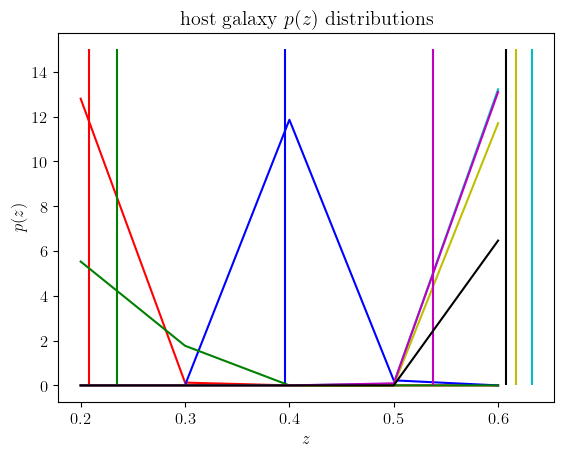

In [13]:
for s in range(n_sne)[:len(colors)]:
    plt.plot(z_mids, pzs[s], color=colors[s])
    plt.vlines(true_params[s]['z'], 0., 15., color=colors[s])
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')
plt.title(r'host galaxy $p(z)$ distributions')
plt.savefig('plots/host_likelihoods.png')

#### Modeling fitting an observed lightcurve

Based on how existing lightcurve fitters work, a lightcurve is generally assigned a class before its redshift and distance modulus are estimated because the fitting function will differ based on the assigned class.  Thus, we may assume that the lightcurve likelihood is separable as follows:

\begin{align*}
\ln[p(\underline{\ell}_{n} | t_{n}, z_{n}, \mu_{n})] &= \ln[p(\underline{\ell}_{n} | t_{n})] + \ln[p(\underline{\ell}_{n}, t_{n} | z_{n}, \mu_{n})]
\end{align*}

*Lightcurve classification*

The confusion matrix quantifies the probabilities that an item is truly of a certain class given the fact that it has been classified as a different class.  (A more in-depth description of the confusion matrix can be found [here](https://github.com/rbiswas4/SNeLightcurveQualityMetric/blob/master/classification_metric.tex).)  We will use the $p(t_{n}' | \hat{t}_{n})$ elements of the confusion matrix as a proxy for $p(\underline{\ell}_{n} | t_{n})$.  The confusion matrix is specific to each classification method, so we will have to choose one to simulate a realistic mock dataset.  For now, we proceed assuming a fairly trivial confusion matrix giving a 50% chance of correct classification for each type and equal probabilities for all misclassifications.  Obviously this will be revised in the future.

In [16]:
# will need to take this from data of some kind, arbitrary for now
conf_matrix = 0.25 + 0.25 * np.eye(3)
assert np.isclose(np.sum(conf_matrix, axis=1).all(), frac_types.all())
ln_conf_matrix = safe_log(conf_matrix)

*$\chi^{2}$ lightcurve parameter fitting*

In order to produce $p(\underline{\ell}_{n}, t_{n} | z_{n}, \mu_{n})$, we will again introduce the idea of using the true type $t_{n}'$ as a proxy for the lightcurve $\underline{\ell}_{n}$ and a classified type $\hat{t}_{n}$ for the variable type $t_{n}$ that appears in the probability expressions.  If we do this, the quantity we want is really $p(t_{n}', \hat{t}_{n} | z_{n}, \mu_{n})$.  We can obtain this knowing how lightcurve fitters, in general, estimate redshifts $z_{n}$ and distance moduli $\mu_{n}$ under all possible combinations of $t_{n}'$ and $\hat{t}_{n}$.  We will construct functions that aim to simulate the signatures of misclassification in the Hubble diagram.  [find a figure to link to]  Currently, we use placeholder functions that will be replaced later on as information about the consequences of fitting with the wrong function becomes available.  The table below summarizes the fitting function for each true type given a classification of type $Ia$.  All other classified types are assumed to give a distribution that is uniform in $\mu_{n}$ and Gaussian in $z_{n}$ according to the same prescription used for the photo-$z$ PDFs.

| True Type | Functional Form of Ia likelihood |
| :-------: | :------------------------------: |
| Ia | $\vec{\mathcal{N}}((z_{n}'', \mu_{n}''), \underline{\Sigma}_{n})$ where $\underline{\Sigma}_{n}=(\sigma^{2}_{z, Ia}, \sigma^{2}_{\mu, Ia})\times\underline{I}$ and $(z_{n}'', \mu_{n}'')\sim\vec{\mathcal{N}}((z_{n}', \mu_{n}'), \underline{\Sigma}_{n})$ |
| Ibc | $\vec{\mathcal{N}}((z_{n}'', \mu_{n}''), \underline{\Sigma}_{n})$ where $\underline{\Sigma}_{n}=(\sigma^{2}_{z, Ibc}, \sigma^{2}_{\mu, Ibc})\times\underline{I}$ and $(z_{n}'', \mu_{n}'')\sim\vec{\mathcal{N}}((z_{n}', \mu_{n}' - C_{Ibc}), \underline{\Sigma}_{n})$ for survey-wide constant $C_{Ibc}$ |
| II | $\vec{\mathcal{N}}((z_{n}'', \mu_{n}''), \underline{\Sigma}_{n})$ where $\underline{\Sigma}_{n}=(\sigma^{2}_{z, II}, \sigma^{2}_{\mu, II})\times\underline{I}$ and $(z_{n}'', \mu_{n}'')\sim\vec{\mathcal{N}}((z_{n}', C_{II}), \underline{\Sigma}_{n})$ for survey-wide constant $C_{II}$ |

In a future revision, the values of $\sigma^{2}_{z, \tau}$ and $\sigma^{2}_{\mu, \tau}$ for each type $\tau$ will be replaced by random variables themselves representing the intrinsic variation among lightcurves.

In [17]:
# must set nuisance parameters inherent in process of producing interim posteriors from lightcurves
Ia_Ia_var = np.array([0.01, 0.02]) ** 2
Ibc_Ia_delta = 1.
Ibc_Ia_var = np.array([0.01, 0.01]) ** 2
II_Ia_delta = np.mean(mu_mids)
II_Ia_var = np.array([0.01, 0.05]) ** 2
z_sigma = 0.03

# definitely needs more work on what (z, mu) distributions are expected when lightcurves are fit with wrong templates
# just made it flat for now

def fit_Ia(z, mu):
    cake = np.zeros((n_types, n_zs-1, n_mus-1))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, mu]), cov = Ia_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = Ia_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    dist = sps.norm(loc = z, scale = z_sigma)
    z_means = dist.rvs(2)
    cake[1] = sps.norm(loc = z_means[0], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = sps.norm(loc = z_means[1], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    ln_cake = safe_log(cake)
    return ln_cake
    
def fit_Ibc(z, mu):
    cake = np.zeros((n_types, n_zs-1, n_mus-1))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, mu - Ibc_Ia_delta]), cov = Ibc_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = Ibc_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    dist = sps.norm(loc = z, scale = z_sigma)
    z_means = dist.rvs(2)
    cake[1] = sps.norm(loc = z_means[0], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = sps.norm(loc = z_means[1], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    ln_cake = safe_log(cake)
    return ln_cake
    
def fit_II(z, mu):
    cake = np.zeros((n_types, n_zs-1, n_mus-1))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, II_Ia_delta]), cov = II_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = II_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    dist = sps.norm(loc = z, scale = z_sigma)
    z_means = dist.rvs(2)
    cake[1] = sps.norm(loc = z_means[0], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = sps.norm(loc = z_means[1], scale = z_sigma).pdf(z_mids)[:, np.newaxis] / n_mus#np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    ln_cake = safe_log(cake)
    return ln_cake

*The lightcurve likelihood*

Now that the type-specific fitting functions have been established, we may combine all relevant terms.

In [18]:
def fit_any(true_vals):
    if true_vals['t'] == 'Ia':
        ln_cake = fit_Ia(true_vals['z'], true_vals['mu']) + ln_conf_matrix[:, 0, np.newaxis, np.newaxis]
    if true_vals['t'] == 'Ibc':
        ln_cake = fit_Ibc(true_vals['z'], true_vals['mu']) + ln_conf_matrix[:, 1, np.newaxis, np.newaxis]
    if true_vals['t'] == 'II':
        ln_cake = fit_II(true_vals['z'], true_vals['mu']) + ln_conf_matrix[:, 2, np.newaxis, np.newaxis]
    return ln_cake

def fit_all(catalog):
    dessert = []
    for true_vals in catalog:
        dessert.append(fit_any(true_vals))
    return np.array(dessert)

sheet_cake = fit_all(true_params)

We plot a handful of these likelihoods.  Each row is the log-likelihood for a different supernova in the catalog.  The columns represent the log-likelihood in the space of $z$ and $\mu$ (Hubble diagram-space) for that supernova if it were classified as type $Ia$, type $Ibc$ and type $II$.  The true $z$ and $\mu$ for each are also plotted.  The title of each panel gives the true type for each supernova.  We can see the effect on the likelihoods for $z$ and $\mu$ based on each combination of true and classified type.

In [19]:
# happily, these look like what we see in contaminated hubble diagrams!
fig = plt.figure(figsize=(n_types*len(colors), n_sne*len(colors)))
p = 0
for s in range(n_sne)[:len(colors)]:
    for t in range(n_types):
        p += 1
        plt.subplot(n_sne, n_types, p)
        plt.pcolormesh(z_bins, mu_bins, sheet_cake[s][t].T, cmap='viridis')
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='r')
        plt.title('true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.savefig('plots/lc_likelihoods.png')

ValueError: Image size of 2100x700000 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x7f91a81badd0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 2100x700000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 2100x700000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2100x700000 with 42 Axes>

#### The full likelihood

[combine both the host galaxy photometry and supernova lightcurve likelihood components]

In [20]:
# these don't have to be normalized
ln_likelihoods = reg_vals(sheet_cake + ln_pzs[:, np.newaxis, :, np.newaxis])

We plot the combined likelihoods for when lightcurves and host galaxy photometry are available.  For the same supernovae as in the previous plot, you can see how the constraints in $z$ become much narrower when th redshift likelihoods are included.

In [21]:
# this should be visible in all types, but the color scaling is bad for Ibc & II
fig = plt.figure(figsize=(n_types*len(colors), n_sne*len(colors)))
p = 0
for s in range(n_sne)[:len(colors)]:
    for t in range(n_types):
        p += 1
        plt.subplot(n_sne, n_types, p)
        plt.pcolormesh(z_mids, mu_mids, ln_likelihoods[s][t].T, cmap='viridis')#, vmin = 0., vmax = 3.)
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='r')
        plt.title('true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.savefig('plots/sn_likelihoods.png')

ValueError: Image size of 2100x700000 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x7f91a81badd0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 2100x700000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 2100x700000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2100x700000 with 42 Axes>

## Making interim posteriors

The likelihoods we just constructed are all well and good, and they really do exist in nature.  However, they are not things we observers are in general able to obtain.  To use them in inference, we would need to regularly integrate over the entire space of data, which is rarely something we know how to do.  When we run a code that produces the probability distribution of unobservable parameters, it really calculates a posterior, not a likelihood; because its inputs are data, it must be conditioning its estimate on that information.  

In addition to that, any way of estimating our unobservable parameters from data also conditions their posteriors on other information, namely interim priors and selection functions.  In reality, when we perform classification, lightcurve fitting, and photo-$z$ PDF estimation, we are finding interim posteriors $p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n}, \underline{\xi}, \vec{\alpha}, \vec{\beta})$ instead of likelihoods $p(\underline{\ell}_{n}, \vec{f}_{n} | t_{n}, z_{n}, \mu_{n})$, due to the assumptions about the distributions of our latent variables and the propagation of selection effects on the data.  In our case, choices of the interim hyperpriors $\underline{\xi}$ will translate directly into a prior belief about the `3D` distribution $p(t, z, \mu | \underline{\xi}, \vec{\alpha}, \vec{\beta})$ that is independent of any observations (and thus independent of $n$).

### Choosing interim priors

To transform our likelihoods into interim posteriors that accurately represent what we expect a real data analysis pipeline to produce, we must choose interim priors.  The interim prior represents the $p(t, z, \mu)$ that is used in the estimation of log-posterior probabilities -- our assumptions about $p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n})$ are parametrized by the interim prior parameters comprising $\underline{\xi}$, so the closest we can get to the desired posteriors is the interim posteriors $\ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n}, \underline{\xi})] = \ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n})] + \ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\xi})]$.  

This section is about making the interim prior $\ln[p(t, z, \mu | \underline{\xi})]$.  We will set a uniform prior on the redshift-dependent supernova proportions and use the WMAP values of the cosmological parameters with grossly inflated error bars to restrict the parameter space of $z$ and $\mu$.

In [34]:
# flat prior on redshift-dependent SNe proportions
interim_n_of_z = np.ones((n_types, n_zs-1))
interim_n_of_z /= np.sum(interim_n_of_z * z_difs[np.newaxis, :])
assert np.isclose(np.sum(interim_n_of_z * z_difs[np.newaxis, :]), 1.)
interim_ln_n_of_z = safe_log(interim_n_of_z)

# WMAP, with 10 * errors so we can see what's going on in crappy plots
interim_H0 = 70.0
delta_H0 = 2.2 * 10.
interim_Om0 = 1. - 0.721
delta_Om0 = 0.025 * 10.
interim_cosmo_hyperparams = np.array([interim_H0, interim_Om0])
interim_cosmo_hyperparam_sigmas = np.array([delta_H0, delta_Om0])
interim_cosmo_hyperparam_vars =  interim_cosmo_hyperparam_sigmas * np.eye(n_hyperparams)
interim_dist = sps.multivariate_normal(mean = interim_cosmo_hyperparams, cov = interim_cosmo_hyperparam_vars)
interim_cosmo = cosmology.FlatLambdaCDM(H0=interim_H0, Om0=interim_Om0)

# may have to change this if nontrivial covariances between hyperparameters
interim_hyperparams = {}
interim_hyperparams['theta'] = np.array([interim_cosmo_hyperparams, interim_cosmo_hyperparam_sigmas])
interim_hyperparams['phi'] = interim_ln_n_of_z

We must now define a function that produces the posterior probability of a supernova taking the value of a particular pair $(z, \mu)$ under a given set of cosmological parameters $\vec{\Omega}$.

In [35]:
def inverter(z, mu):
    #note: this inverter is slow! perhaps we could speed it up with interpolation over predefined grids?
    def cosmo_helper(hyperparams):
        return np.array([abs(cosmology.FlatLambdaCDM(H0=hyperparams[0], Om0=hyperparams[1]).distmod(z).value - mu)])
    solved_cosmo = spo.minimize(cosmo_helper, interim_hyperparams['theta'][0], method="Nelder-Mead", options={"maxfev": 1e5, "maxiter":1e5})
    ln_prob = interim_dist.logpdf(solved_cosmo.x)
    return ln_prob#max(prob, sys.float_info.epsilon)

Using this function, we can construct an interim prior probability, which has the dimensions of a single `3D` probability distribution.

In [36]:
# note the approximation of cdf[z_min, z_max] = pdf[z_mid]
interim_sheet = np.zeros((n_zs-1, n_mus-1))
for z in range(n_zs-1):
    for mu in range(n_mus-1):
        ln_prob = inverter(z_mids[z], mu_mids[mu])
        interim_sheet[z][mu] = ln_prob
interim_ln_prior = reg_vals(interim_ln_n_of_z[:, np.newaxis] + interim_sheet[np.newaxis, :])
interim_prior = np.exp(interim_ln_prior)
interim_prior /= np.sum(interim_prior * z_dif * mu_difs[np.newaxis, np.newaxis, :])
interim_ln_prior = safe_log(interim_prior)
assert np.isclose(np.sum(interim_prior * z_dif * mu_difs[np.newaxis, np.newaxis, :]), 1.)

We plot the log of the interim prior and show that it is reasonable but not too restrictive.

FileNotFoundError: [Errno 2] No such file or directory: '/home/aimalz/Code/LSSTDESC/scippr/code/demos/plots/interim_prior.png'

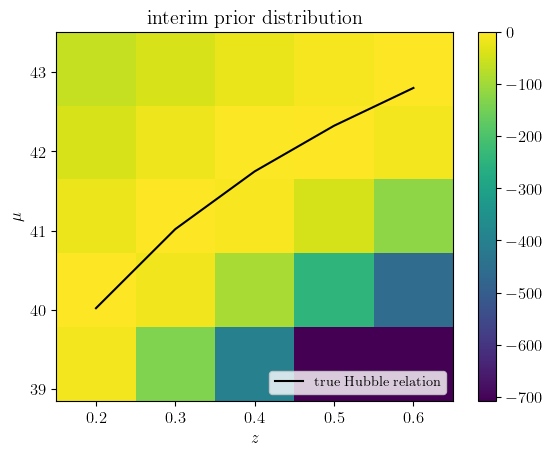

In [37]:
# the interim prior and truth are way too close to each other. . . but that's realistic
plt.pcolormesh(z_mids, mu_mids, interim_ln_prior[0].T, cmap='viridis')#, vmin = 0., vmax = 3.)
plt.plot(z_mids, [true_cosmo.distmod(z).value for z in z_mids], color='k', label='true Hubble relation')
plt.title('interim prior distribution')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend(loc='lower right', fontsize='small')
plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.colorbar()
plt.savefig('plots/interim_prior.png')

### Selection Functions

We have not yet included selection effects in this treatment.  The graphical model included known hyperparameters $\vec{\alpha}$ and $\vec{\beta}$ to represent the selection function for supernova lightcurves and host galaxy photometry.  If these hyperparameters are known, then we can safely say we know $p(\underline{\ell}_{n} | \vec{\alpha})$ and $p(\vec{f}_{n} | \vec{\beta})$ for all supernovae $n$ in our catalog.  However, what we really need is $p(t_{n}, z_{n}, \mu_{n} | \vec{\alpha}, \vec{\beta})$.  We obtain these using an approach similar to <a href="https://github.com/ixkael/Photoz-tools/blob/master/Photoz%20galaxy%20survey%20mock%20and%20N(z)%20inference.ipynb">that of Boris Leistedt</a>.  *Actually, I'm not really sure how to relate what we're doing, which we discussed with Boris, to what's in his notebook.*

*The host galaxy redshift selection function*

The selection function can be represented by $\ln[p(z | \vec{\beta})]$.  A selection function in which $\vec{\beta}$ is comprised of magnitude limits in all photometric bands is commonly imposed on galaxy surveys, such that $p(\vec{f} | \vec{\beta})$ is known (and often is a step function in as many dimensions as there are filters).  Furthermore, we have a reasonably good idea of what $p(z | \vec{f})$ is.  The selection function we want is just $\int\ p(z | \vec{f})\ p(\vec{f} | \vec{\beta})\ d\vec{f}$.  

In [38]:
# We emulate this using data from a realistic galaxy simulation.
# We want the number of galaxies as a function of redshift, SED type, and luminosity.
# (Buzzard, for example, includes this.)
# Using a realistic set of magnitude limits, we want to calculate the recovered fraction
# of galaxies as a function of redshift, SED type, and luminosity.
# Then we just integrate over SED type and luminosity to get $p(z | \vec{\beta})$

*The supernova lightcurve selection function*

The supernova lightcurve selection function will be more complicated than the host galxy photometry selection function for a variety of reasons.

*We are actively considering strategies for implementation in our mock data, with two main approaches.*

_Empirical proposal_

We want to go directly to $p(t, z, \mu | \vec{\alpha})$ knowing only $p(\underline{\ell} | \vec{\alpha})$ and $p(t, z, \mu | \underline{\ell})$.  We note that in the empirical approach, because $\mu$ is determined by $z$ in the probailistic graphical model, we can say $p(t, z, \mu | \vec{\alpha}) = p(t, z | \vec{\alpha}) = \int\ p(t, z | \underline{\ell})\ p(\underline{\ell} | \vec{\alpha})\ d\underline{\ell}$.

In [89]:
def parse_ratio_file(filepath):
    with open(filepath, 'rb') as rat_file:
        tuples = (line.split(None) for line in rat_file)
        ratdata = [[pair[k] for k in range(0,len(pair))] for pair in tuples]
    filezs = np.array([float(ratdata[i][0]) for i in range(2, len(ratdata))])
    rat_data = np.zeros((len(filezs), n_types))
    for z in range(len(filezs)):
        for t in range(n_types):
            rat_data[z][t] = float(ratdata[z+2][2 * t + 1])
# wfd_data = np.array([np.array([int(wfddata[i][2 * j]) for j in range(1, ntypes)]) for i in range(2, len(wfd_data))])
    rat_data[np.isnan(rat_data)] = 0.
    return rat_data

In [98]:
# We emulate this using data from a realistic supernova simulation.
# We want the number of supernovae as a function of redshift and SN type.
# (The cadence studies with SNANA should have this.)
# Using a realistic set of selection cuts, we want to calculate the recovered fraction
# of SN as a function of SN type and redshift under a given survey strategy
# relative to the "best possible" survey strategy.
# with open('data/ratios_wfd.txt', 'r') as wfd_file:
# #     wfd_file.next()
#     tuples = (line.split(None) for line in wfd_file)
#     wfddata = [[pair[k] for k in range(0,len(pair))] for pair in tuples]
# filezs = np.array([float(wfddata[i][0]) for i in range(2, len(wfddata))])
# # print(filezs)
# wfd_data = np.array([np.array([int(wfddata[i][2 * j]) for j in range(1, ntypes)]) for i in range(2, len(wfd_data))])
# wfd_data[np.isnan(wfd_data)] = 0.
wfd_data = parse_ratio_file('data/ratios_wfd.txt')
print(wfd_data)
# with open('data/ratios_ddf.txt', 'r') as ddf_file:
# #     ddf_file.next()
#     tuples = (line.split(None) for line in ddf_file)
#     ddfdata = [[pair[k] for k in range(0,len(pair))] for pair in tuples]
# ddf_data = np.array([np.array([float(ddfdata[i][2 * j]) for j in range(1, int((len(ddfdata[i])/2)+1))]) for i in range(2, len(ddf_data))])
ddf_data = parse_ratio_file('data/ratios_ddf.txt')
print(ddf_data)
# these are the recovery rates
# sn_sel_fun = (wfd_data/sum(wfd_data)) / (ddf_data/sum(ddf_data))
# sn_sel_fun /= sum(sn_sel_fun)
# sn_sel_fun = sn_sel_fun.T
# print(sn_sel_fun)
# It's actually a big problem for the selection function to go to 0 or exceed 1.

[[0.75447396 0.38022896 0.33926133]
 [0.63744891 0.34129838 0.31528651]
 [0.5922367  0.36979637 0.3565433 ]
 [0.57905821 0.3496453  0.32112324]
 [0.58075558 0.31873305 0.38270848]
 [0.57933813 0.         0.37153139]
 [0.50569831 0.         0.40101025]
 [0.50246064 0.         0.        ]
 [0.57818    0.         0.        ]]
[[0.96133447 0.0777277  0.1629344 ]
 [0.92847597 0.12217534 0.06003003]
 [0.82600011 0.14882061 0.10259411]
 [0.73509491 0.178501   0.12692537]
 [0.6974766  0.19919222 0.14411893]
 [0.64997414 0.17466448 0.14337027]
 [0.59096212 0.21511355 0.11875256]
 [0.59798013 0.24548764 0.16922105]
 [0.5883197  0.42785142 0.22209181]]


TODO: plot the selection functions and check that they're normalized as needed

also SOMETHING'S BROKEN PAST HERE

In [99]:
#purity = # real classified as real / all classified as real
#want real classified as real / all true real
#for now using purity as what we want
#should use really low purity for testing to check that it's doing something!
#need this to be # types * # z bins in shape
interpolator = spi.interp1d(wfd_data.T[0], wfd_data.T[1])
interpolated = interpolator(z_mids)
sn_sel_fun = np.vstack((interpolated, 1.*interpolated/3., 2.*interpolated/3.))
#should divide this by DDF, for now say it's perfect
sn_sel_fun /= np.ones((n_types, n_zs))
for t in range(n_types):
    plt.plot(z_mids, sn_sel_fun[t])
plt.xlabel(r'$z$')
plt.ylabel('recovery fraction')
plt.savefig('plots/lc_sel_func')
#label this
#will need this for inference, should write to file and skeleton should read it in
sn_sel_fun_norm = np.sum(sn_sel_fun * z_difs[np.newaxis, :])
sn_sel_fun /= sn_sel_fun_norm
assert np.isclose(np.sum(sn_sel_fun * z_difs[np.newaxis, :]), 1.)
ln_sn_selection_function = safe_log(sn_sel_fun)

ValueError: A value (0.2) in x_new is below the interpolation range's minimum value (0.502460638462).

_Model-based proposal_

If the selection cuts aren't in the space of lightcurves but are in the space of lightcurve fit parameters $x$, $m$, and $c$, we have a slightly different approach.  In this case, we have $p(t, z, \mu | \vec{\alpha}) = \iiint\ p(t, z, \mu | x, m, c)\ p(x, m, c | \vec{\alpha})\ dx\ dm\ dc$.  

In [ ]:
# We emulate this using data from a realistic supernova simulation.
# We want the number of supernovae as a function of their fit parameters.
# (The cadence studies with SNANA should have this.)
# Using a realistic set of selection cuts, we want to calculate the recovered fraction
# of SN as a function of SN type, redshift, and distance modulus
# under a given survey strategy relative to the "best possible" survey strategy.
host_sel_fun = np.ones(n_zs)
host_sel_fun_norm = np.sum(host_sel_fun * z_difs)
host_sel_fun /= host_sel_fun_norm
assert np.isclose(np.sum(host_sel_fun * z_difs), 1.)
ln_host_selection_function = safe_log(host_sel_fun)

We wrap up the simulation/emulation of the selection functions by combining the terms as follows: $\ln[p(t, z, \mu | \vec{\alpha}, \vec{\beta})] = \ln[p(t, z, \mu | \vec{\alpha})] + \ln[p(z | \vec{\beta})]$

In [ ]:
# put together those terms

selection_sheet = np.zeros((n_types, n_zs, n_mus))
ln_selection_function = reg_vals(ln_sn_selection_function[:, np.newaxis] + ln_host_selection_function[np.newaxis, :, np.newaxis] + selection_sheet)
selection_function = np.exp(ln_selection_function)
sel_fun_norm = np.sum(selection_function * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :] / n_types)
selection_function /= sel_fun_norm
assert np.isclose(np.sum(selection_function * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :] / n_types), 1.)
ln_selction_function = safe_log(selection_function)

## Final result: the mock interim posteriors

We will create mock interim posteriors according to the following, based on Bayes' Rule.

\begin{align*}
\ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n}, \underline{\xi}, \vec{\alpha}, \vec{\beta})] &\propto \ln[p(\underline{\ell}_{n}, \vec{f}_{n} | t_{n}, z_{n}, \mu_{n})] + \ln[p(t, z, \mu | \vec{\alpha}, \vec{\beta})] + \ln[p(t, z, \mu | \vec{\xi})]
\end{align*}

In [ ]:
# note likelihoods were not normalized; this must be normalized
interim_ln_posteriors = reg_vals(ln_likelihoods + interim_ln_prior[np.newaxis, :] + ln_selection_function)
interim_posteriors = np.exp(interim_ln_posteriors)
interim_posteriors /= np.sum(interim_posteriors * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
interim_ln_posteriors = safe_log(interim_posteriors)
print np.shape(interim_posteriors), np.shape(interim_ln_posteriors)
print np.shape(interim_posteriors[2][0]), np.shape(interim_ln_posteriors[2][0])
# print zip(interim_posteriors[2][0], interim_ln_posteriors[2][0])
interim_ln_posteriors = ln_likelihoods + interim_ln_prior[np.newaxis, :]
interim_posteriors = np.exp(interim_ln_posteriors)
interim_posteriors /= np.sum(interim_posteriors * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
assert np.isclose(np.sum(interim_posteriors * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)

We plot a few examples of the final mock interim posteriors.  These will be the input to `scippr`!

In [ ]:
# these are going to get a lot narrower
fig = plt.figure(figsize=(n_types*len(colors), n_sne*len(colors)))
p = 0
for s in range(n_sne)[:len(colors)]:
    for t in range(n_types):
        p += 1
        plt.subplot(n_sne, n_types, p)
        plt.pcolormesh(z_mids, mu_mids, interim_ln_posteriors[s][t].T, cmap='viridis')#, vmin = 0., vmax = 3.)
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='r')
        plt.title('true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.savefig('plots/out_interim_posteriors.png')

[write data to file]

In [ ]:
# write true hyperparameters just to check

truth = {}
binned_n_of_z = np.zeros((n_types, n_zs))
for t in range(n_types):
    cdfs = true_n_of_z[t].cdf(z_bins)
    binned_n_of_z[t] = (cdfs[1:] - cdfs[:-1])
binned_n_of_z = frac_types[:, np.newaxis] * np.array(binned_n_of_z)# / z_range
binned_n_of_z /= np.sum(binned_n_of_z * z_difs[np.newaxis, :])
assert np.isclose(np.sum(binned_n_of_z * z_difs[np.newaxis, :]), 1.)
truth['phi'] = binned_n_of_z
truth['theta'] = true_hyperparams
truth['data'] = true_params

with open('data/truth.hkl', 'w') as true_file:
    hickle.dump(truth, true_file)

# write axes (types, z_bins, mu_bins)
# write interim prior (interim_ln_prior)
# write interim posteriors (ln_interim_posteriors)

output = {'types': types, 'z_bins': z_bins, 'mu_bins': mu_bins}
output['ln selection function'] = ln_selection_function
output['interim ln prior'] = interim_ln_prior
output['interim ln posteriors'] = interim_ln_posteriors

with open('data/data.hkl', 'w') as out_file:
    hickle.dump(output, out_file)

# Scratch space (Please ignore after this point!)

In [ ]:
# I was sort of proud of writing this function that taught me some array manipulation stuff, so I'm keeping it here for now.
def sample_discrete(dist, N, discs, difs, bins):
    out_info = []
    norm_dist = dist * difs[np.newaxis, :]
    assert np.isclose(np.sum(norm_dist), 1.)
    dist_shape = np.shape(norm_dist)
    flat_dist = norm_dist.flatten()
    cdf = np.cumsum(flat_dist)
    for n in range(N):
        each = {}
        r = np.random.random()
        k = bisect.bisect(cdf, r)
        (t_ind, z_ind) = np.unravel_index(k, dist_shape)
        each['t'] = discs[t_ind]
        each['z'] = np.random.uniform(low=bins[z_ind], high=bins[z_ind + 1])
        out_info.append(each)
    return out_info